dataset : https://www.kaggle.com/c/street-view-getting-started-with-julia

In [335]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from skimage import io
from skimage import color
from skimage import feature
from skimage import transform
%matplotlib inline

In [336]:
#labels csv
labels_ = [] # first line is dirty
with open('./trainLabels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels_.append(row[1])


In [337]:
#loading the dataset
images = []
labels = []
SAMPLE_DIR = './trainResized'
for i, label in enumerate(labels_):
    if i == 0 : continue
    labels.append(label)
    im = io.imread('{}/{}.Bmp'.format(SAMPLE_DIR, i))
    gray = color.rgb2gray(im)
    ############edges = feature.canny(gray)
    images.append(gray)

images = np.array(images)
labels = np.array(labels)

print (images.shape, labels.shape)

(6283, 20, 20) (6283,)


In [338]:
# filtering the set
# this is optional!
letters = ['A', 'B', 'C', 'D', 'E','X', 'Y', '1', '2','3', '4', '5']

mask = (labels == letters[0])
for i in range(len(letters)-1):
    mask = mask | (labels == letters[i+1])

images = images[mask]
labels = labels[mask]
print (images.shape, labels.shape)

#label stats
def label_stats(labels, letters):
    stats = {}
    for letter in letters:
        stats[letter] = len(labels[labels == letter])
    return stats

print (label_stats(labels, letters))

(1576, 20, 20) (1576,)
{'B': 90, 'A': 459, '2': 59, '4': 37, 'E': 357, 'Y': 54, 'X': 43, '5': 41, 'D': 165, '1': 65, 'C': 170, '3': 36}


In [339]:
# generates more images the way that every sample has equal number
def generate_and_eq_more_images(images, labels, letters):
    
    im_list = images.tolist()
    labels_list = labels.tolist()
    
    stats = label_stats(labels, letters)
    max_sample_size = max(stats.values()) # the maximus sample size
    print ("Max: ", max_sample_size )
    for letter in letters:
        samples_to_gen = max_sample_size - stats[letter] # number of new samples to be generated
        sample_images = images[labels == letter] # original image sample, this is the source for the generated images
        print("label ", letter, samples_to_gen)
        for i in range(samples_to_gen): #adding generated images N times
            random_im = sample_images[random.randint(0,len(sample_images)-1)]
            im_list.append(gen_transform(random_im))
            labels_list.append(letter)
            
    return np.array(im_list), np.array(labels_list)
    
def gen_transform(im):
    new_im = transform.rotate(im, random.randint(-20, 20))
    return new_im
    
    
    
images, labels = generate_and_eq_more_images(images, labels, letters)

print (images.shape, labels.shape)
print (label_stats(labels, letters))

Max:  459
label  A 0
label  B 369
label  C 289
label  D 294
label  E 102
label  X 416
label  Y 405
label  1 394
label  2 400
label  3 423
label  4 422
label  5 418
(5508, 20, 20) (5508,)
{'B': 459, 'A': 459, '2': 459, '4': 459, 'E': 459, 'Y': 459, 'X': 459, '5': 459, 'D': 459, '1': 459, 'C': 459, '3': 459}


In [340]:
## the canny transform
im_list = []
for i in range(len(images)):
    im_list.append(feature.canny(images[i]))
images = np.array(im_list)

In [341]:
# preprocessing
# not needed for support vector!
ENCODER = preprocessing.LabelBinarizer()
ENCODER.fit(labels)
print(ENCODER.classes_)

##############labels = ENCODER.transform(labels)



['1' '2' '3' '4' '5' 'A' 'B' 'C' 'D' 'E' 'X' 'Y']


E


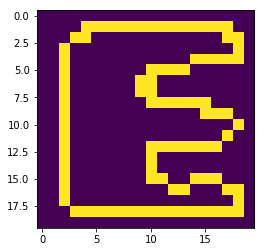

In [342]:
N = 111
print(labels[N])
i = images[N]

plt.imshow(i)



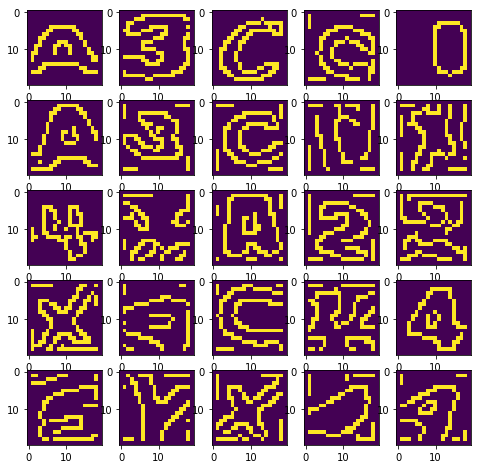

In [343]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images[random.randint(0, len(images)-1)])

In [344]:
data_x = images.reshape(images.shape[0],-1)
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, labels, test_size=0.33, random_state=44)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(3690, 400) (1818, 400) (3690,) (1818,)


In [345]:
#clf = svm.SVC()
clf = ensemble.RandomForestClassifier()

clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.99783197831978321

In [346]:
pred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print (score)

0.73102310231


[[ 87   6   2   8   4   1   1  17  15   6  14   1]
 [  8 107   2   0  15   0   2   6   3   2   3   4]
 [  5   2 105  10   1   2   0  14   6   4   6   1]
 [  9   7  10  87   0   2   3   5   4   5   2   3]
 [  8  15   4   4  78   4   2   9   9   4   3  12]
 [  8   5   3   4   3 114   5   9   7   2   2   5]
 [  0   1   2   3   1   5 107   4   6   0   1   3]
 [  2   3   3   7   1   2   2 114   7   4   1   1]
 [  2   0   2   0   1   0   3   7 120   4   3   4]
 [  1   1   0   1   0   0   0   2   6 139   0   2]
 [  3   1   1   1   1   0   0   3   1   2 138   0]
 [  2   9   0   1   3   0   0   5   4   3   3 133]]


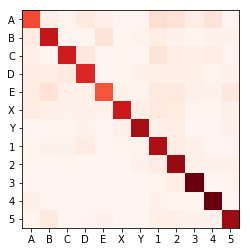

In [347]:
cm = metrics.confusion_matrix(y_test, pred, labels=letters)
print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)